# GPR
 * For the Centric/Acentric Case
     * For 1,000, 5,000, 10,000 pts
         * Optimize hyperparameters
         * report RMS
 * By convention, X_s is the sampling points (where I'll test GPR), and X_t is for points used in training

#### Imports and Function Defs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import itertools
import math
import scipy.optimize
from math import ceil

In [2]:
%run ../../CoreTools/CoreFunctions.ipynb

### GPR Function Defs

In [3]:
@nb.njit(cache=True)
def rbf(xp, xq, l, sf):
    return sf*sf*np.exp(-.5 * np.sum(np.power((xp-xq)/l, 2)))

In [4]:
@nb.njit(parallel=True)
def K_XY(X, Y, l, sf):
    cov = np.empty((len(Y),len(X)))
    for i in nb.prange(len(Y)):
        for j in range(len(X)):
            cov[i,j] = rbf(Y[i], X[j], l, sf)
    return cov

In [5]:
@nb.njit(parallel=True)
def predict(X, X_s, l, sf, k_xx_i_y, y_mean):
    return np.dot(K_XY(X, X_s, l, sf), k_xx_i_y) + y_mean

In [6]:
def fitPredict(X_train, y_train, X_test, l, sf):

    k_xx = K_XY(X_train, X_train, l, sf)
    y_mean = np.mean(y_train)
    k_xx_i_y = scipy.sparse.linalg.minres(k_xx, y_train-y_mean)[0] 
    pred = predict(X_train, X_test, l, sf, k_xx_i_y, y_mean)
    
    return pred, k_xx_i_y

Compile optimized code rn

In [7]:
p, k = fitPredict(np.random.random((2,4)), np.random.random(2), np.random.random((10,4)), np.ones(4), 1.)

### Hyperparameter Tuning Function Defs

In [8]:
def res(params, X_training, y_training, X_sampling, y_sampling, verbose=True):
    l = params[:-1]
    sf = params[-1]
            
    pred, k_xx_i_y = fitPredict(X_training, y_training, X_sampling, l, sf)
    
    r = np.sqrt(np.mean(np.power(y_sampling-pred, 2)))
    if verbose: print(r, params)

    return r

### Training & Sampling Data

In [9]:
N = 18

In [10]:
epsilon = 1.1e-2
Ec_start = 1e-5; Ec_end = 5.
sA_start = 1e-5; sA_end = 1-epsilon
Z0_start = -5; Z0_end = 25
sZ_start = 1e-5; sZ_end = 5

## GPR on Centric Case

In [11]:
X, y = np.load('../../data/Centric_X.npy'), np.load('../../data/Centric_y.npy')

In [12]:
c = np.linalg.solve(X.T@X, X.T@y)
c

array([ 0.0029642 ,  0.07308452, -0.00221497,  0.00446096], dtype=float32)

In [13]:
y -= X @ c

In [14]:
sampling_size = np.append(np.arange(100, 1000, 100), np.arange(1000, 10**4+10**3, 10**3))
sampling_size

array([  100,   200,   300,   400,   500,   600,   700,   800,   900,
        1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
       10000])

In [15]:
tuning_rate = np.append([500, 300], 200*np.ones(len(sampling_size)-2))
tuning_rate

array([500., 300., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200.])

In [16]:
test_size = ceil(len(X)/2e4)
test_size

5

In [17]:
l = None

In [18]:
centric_RMS = np.empty(len(sampling_size))

In [19]:
plt.figure(figsize=(25,15))
for i, size in enumerate(sampling_size):
    step_size = ceil(len(X)/size)
    
    if l is None: res_args = np.ones(5)
    else: res_args = np.append(l, sf)

    best = scipy.optimize.minimize(res, res_args, 
                                   args=(X[::step_size], y[::step_size], X[::test_size], y[::test_size], False),
                                   method='Nelder-Mead', options={'maxfev':tuning_rate[i]})

    l = best.x[:-1]
    sf = best.x[-1]
    
    p, k = fitPredict(X[::step_size], y[::step_size], X, l, sf)
    
    err = p-y
    
    rms = np.sqrt(np.mean(np.power(err, 2)))

    print('with size of {}, best params are'.format(size),l,sf,'and rms error is ', np.around(rms,3))
    centric_RMS[i] = rms

with size of 100, best params are [0.56664574 0.12219316 1.52095183 1.92672143] 1.2872533952960006 and rms error is  0.073
with size of 200, best params are [0.39577348 0.06500816 1.44862196 2.35624139] 1.8559888330151322 and rms error is  0.072
with size of 300, best params are [ 3.17231145  0.59776669 -1.71645535  7.05483663] -11.54152262591451 and rms error is  0.065
with size of 400, best params are [ 3.0532361   0.59157633 -1.95047371  6.90360782] -11.545413138722399 and rms error is  0.062
with size of 500, best params are [ 1.76225786  0.3109759  -3.6568168   6.84670887] -12.606941489838018 and rms error is  0.054
with size of 600, best params are [ 1.85516872  0.37645277 -2.29866522  7.44961739] -13.470183266436019 and rms error is  0.057
with size of 700, best params are [ 1.681602    0.43218099 -2.19641502  4.59001475] -15.189974448408591 and rms error is  0.05
with size of 800, best params are [ 2.09718342  0.16595347 -2.42695549  5.90747088] -15.306463954477275 and rms erro

<Figure size 1800x1080 with 0 Axes>

In [28]:
len(X[::31])

3090

In [30]:
%%time
p,k = fitPredict(X[::31], y[::31], X, np.array([ 0.39343298, 0.19350809, -0.11562606, 2.09609578]), -5.541959326513697)

CPU times: user 7min 47s, sys: 1.18 s, total: 7min 49s
Wall time: 41.7 s


## GPR on Acentric Case

In [20]:
X, y = np.load('../../data/Acentric_X.npy'), np.load('../../data/Acentric_y.npy')

In [21]:
c = np.linalg.solve(X.T@X, X.T@y)
c

array([ 0.00552832,  0.02997149, -0.00183045,  0.00619168], dtype=float32)

In [22]:
y -= X @ c

In [23]:
sampling_size = np.append(np.arange(100, 1000, 100), np.arange(1000, 10**4+10**3, 10**3))
sampling_size

array([  100,   200,   300,   400,   500,   600,   700,   800,   900,
        1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
       10000])

In [24]:
tuning_rate = np.append([500, 300], 200*np.ones(len(sampling_size)-2))
tuning_rate

array([500., 300., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200.])

In [25]:
test_size = ceil(len(X)/2e4)
test_size

5

In [26]:
l = None

In [27]:
acentric_RMS = np.empty(len(sampling_size))

In [28]:
plt.figure(figsize=(25,15))
for i, size in enumerate(sampling_size):
    step_size = ceil(len(X)/size)
    
    if l is None: res_args = np.ones(5)
    else: res_args = np.append(l, sf)

    best = scipy.optimize.minimize(res, res_args, 
                                   args=(X[::step_size], y[::step_size], X[::test_size], y[::test_size], False),
                                   method='Nelder-Mead', options={'maxfev':tuning_rate[i]})

    l = best.x[:-1]
    sf = best.x[-1]
    
    p, k = fitPredict(X[::step_size], y[::step_size], X, l, sf)
    
    err = p-y
    
    rms = np.sqrt(np.mean(np.power(err, 2)))

    print('with size of {}, best params are'.format(size),l,sf,'and rms error is ', np.around(rms,3))
    acentric_RMS[i] = rms

with size of 100, best params are [2.0306805  0.59174805 1.88577429 3.43541072] -0.5288958742325587 and rms error is  0.031
with size of 200, best params are [2.66131451 0.43702335 1.63299566 2.06759455] -0.6085390631903793 and rms error is  0.027
with size of 300, best params are [1.07867995 0.32119054 1.07524899 1.91545521] -1.7771977827663021 and rms error is  0.027
with size of 400, best params are [1.95870796 0.54448398 1.45614421 1.5573373 ] -1.7050965390455664 and rms error is  0.028
with size of 500, best params are [1.66167468 0.46377807 1.72039503 1.77989488] -1.7002693344685818 and rms error is  0.024
with size of 600, best params are [1.52814143 0.435603   0.96209517 1.24522882] -4.579163740782452 and rms error is  0.02
with size of 700, best params are [1.06531361 0.43262071 0.79880131 1.35290579] -5.8735917449808674 and rms error is  0.021
with size of 800, best params are [1.11095435 0.31859391 0.7592182  1.72212529] -5.828009384675116 and rms error is  0.021
with size o

<Figure size 1800x1080 with 0 Axes>

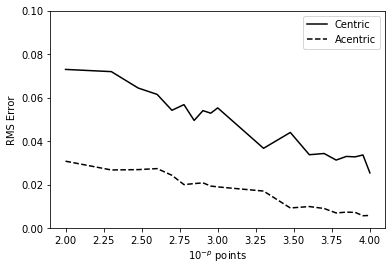

In [31]:
plt.plot(np.log10(sampling_size), centric_RMS, color='black', label='Centric')
plt.plot(np.log10(sampling_size), acentric_RMS, color='black', linestyle='--', label='Acentric')
plt.ylim((0,.1))
plt.legend();
plt.ylabel('RMS Error')
plt.xlabel('$10^{-p}$ points')
plt.savefig('gpr_Results.png', bbox_inches='tight', pad_inches=0);